In [1]:
import pandas as pd
import numpy as np
import torch
import torch. nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import open3d as o3d
from sklearn.metrics import recall_score, accuracy_score, confusion_matrix, f1_score

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [20]:
class MyDataset(Dataset):
    def __init__(self, image, array, target, visual, cell_size, grid_size=1, balance_set=False):
        self.image = image            
        self.array = array
        self.target = target
        self.visual = visual # x, y, z 
        self.cell_size = cell_size
        self.grid_size = grid_size

        self.maxx, self.maxy, self.numz = self.image.shape # size of data-block

        self.balance_set = balance_set

        if balance_set:
            self.positive = np.argwhere(self.target > 0.5)
            self.negative = np.argwhere(self.target <= 0.5)

    def __getitem__(self, idx):

        index = idx

        # Balance by alternating between random positive and negative sample
        if self.balance_set:
            if index % 2 == 0:
                index = self.positive[np.random.randint(len(self.positive))][0]
            else:
                index = self.negative[np.random.randint(len(self.negative))][0]
        
        vals = self.array[index]        
        x, y, z, quality = vals

        # Create X vector
        X = [quality, z] # Removed position from array, are they needed here?

        # - cw, cy : find cell position based on x and y
        cw = int(x / self.cell_size)
        ch = int(y / self.cell_size)

        # Create Y vector of desired size with default -1 values
        Y = np.full((2*self.grid_size + 1, 2*self.grid_size + 1, 4), -1.)

        # Prepare slicing parameters
        fx0, fx1 = cw - self.grid_size, cw + self.grid_size + 1
        fy0, fy1 = ch - self.grid_size, ch + self.grid_size + 1
        tx0 = -fx0 if fx0 < 0 else 0
        ty0 = -fy0 if fy0 < 0 else 0
        tx1 = 2*self.grid_size + 1
        ty1 = 2*self.grid_size + 1
        fx0 = max(0, fx0)
        fy0 = max(0, fy0)
        if fx1 > self.maxx:
            tx1 = (2*self.grid_size + 1) - (fx1 - self.maxx)
        if fy1 > self.maxy:
            ty1 = (2*self.grid_size + 1) - (fy1 - self.maxy)
        fx1 = min(self.maxx, fx1)
        fy1 = min(self.maxy, fy1)

        # Slice Y vector
        Y[tx0:tx1,ty0:ty1] = self.image[fx0:fx1, fy0:fy1]

        # Reshape
        Y = Y.reshape([4, self.grid_size*2+1, self.grid_size*2+1])

        # Cast to 32 bit for GPU training
        Y = np.float32(Y)
        X = np.float32(np.array(X))
        target = np.expand_dims(np.float32(self.target[index]),-1)

        # Position for visualization
        pos = self.visual[index]        
        x, y, z = pos 
        position = np.float32(np.array([x, y, z]))

        return {"point": X, "grid" : Y, "target" : target, "position": position}

    def __len__(self):
        l = int(len(self.target))
        return int(l)

class NeuralNetwork(nn.Module):
    def __init__(self, input_dim):
        super(NeuralNetwork, self).__init__()
        self.layer_1 = nn.Linear(input_dim, int(input_dim*0.5))
        self.layer_2 = nn.Linear(int(input_dim*0.5), int(input_dim*0.25))
        self.layer_3 = nn.Linear(int(input_dim*0.25), 1)
       
    def forward(self, point, grid):
        grid = torch.flatten(grid, 1) # Flatten the grid
        x = torch.cat((point, grid), 1) # Combine with point

        x = F.relu(self.layer_1(x))
        x = F.relu(self.layer_2(x))
        x = torch.sigmoid(self.layer_3(x))

        return x
    
    def save(self, path):
        torch.save(self.state_dict(), path)

    def load(self, path):
        self.load_state_dict(torch.load(path, map_location=torch.device("cpu")))
        self.eval()

In [5]:
# Load data
read_test = pd.read_csv("data/ac_felt2_test.csv") # Felt2_EW
test_grid = np.load("data/ac_felt2_c05_test.npy") 

In [21]:
BATCH_SIZE = 512
GRID_SIZE = 1
CELL_SIZE = 0.5

In [22]:
# Normalize
data = read_test.copy()
data["z"] = (data.z - np.min(data.z)) / (np.max(data.z) - np.min(data.z))
data["quality"] = (data.quality - np.min(data.quality)) / (np.max(data.quality) - np.min(data.quality))

test_data = np.asarray(data[["x", "y", "z", "quality"]])
test_labels = np.asarray(data["accepted"])
test_visualize = np.asarray(read_test[read_test.columns[0:3]])

In [23]:
test_dataset = MyDataset(test_grid, test_data, test_labels, test_visualize, CELL_SIZE, GRID_SIZE)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE)

In [25]:
# Load model
input_shape = (np.sum([8*i for i in range(GRID_SIZE+1)])*4) + 4 + 2
model = NeuralNetwork(input_shape)
model.load("models/grid_05/grid_size_1/model_dict_512_combination.pt")

In [48]:
model = ConvNeuralNetwork(GRID_SIZE)
model.load("models/grid_01/grid_size_40/conv_model_dict_512_maxpool_es.pt")

## Predict

In [26]:
# Positions
visualPoints = []

# Validation
actual = []
predictions = []
with torch.no_grad():
    for test_data in test_dataloader:
        point, grid, target, position = test_data["point"], test_data["grid"], test_data["target"], test_data["position"]

        # Predict
        pred = model(point, grid)
        
        # Store prediction
        predictions.append(pred.numpy())

        # Store actual 
        actual.append(target.numpy())

        # Store positions
        visualPoints.append(position.numpy())

## Evaluate

In [27]:
def evaluate_result(predictions, actual, threshold):
    preds = []
    acts = []

    for bx, batches in enumerate(predictions):
        for by, batch in enumerate(batches):
            if predictions[bx][by] > threshold:
                preds.append(1)
            else:
                preds.append(0)

            if actual[bx][by] > threshold:
                acts.append(1)
            else:
                acts.append(0)

    return preds, acts

In [28]:
def get_scores(predictions, actual):
    confusion = confusion_matrix(actual, predictions)
    accuracy = accuracy_score(actual, predictions)
    recall = recall_score(actual, predictions)
    f1 = f1_score(actual, predictions)

    print("Confusion matrix:")
    print(confusion)
    print("\n")

    print("Accuracy score:")
    print(accuracy)
    print("\n")

    print("Recall score:")
    print(recall)
    print("\n")

    print("F1 score:")
    print(f1)
    print("\n")

In [29]:
preds, acts = evaluate_result(predictions, actual, 0.5)

In [30]:
get_scores(preds, acts)

Confusion matrix:
[[   9910    4250]
 [  56259 1012394]]


Accuracy score:
0.9441186982424481


Recall score:
0.9473552219476294


F1 score:
0.9709830302350217




## Visualize

In [31]:
xyz_points = []
for bx, batches in enumerate(visualPoints):
    for by, batch in enumerate(batches):
        xyz_points.append([visualPoints[bx][by][0], visualPoints[bx][by][1], visualPoints[bx][by][2]])

In [32]:
visualize_df = pd.DataFrame(xyz_points, columns=["x", "y", "z"])
visualize_df["accepted"] = preds

In [33]:
def visualize_area(data_area, voxel_size=0.02):
    _x = np.array(data_area.x)
    _y = np.array(data_area.y)
    _z = np.array(data_area.z)

    _red = np.array(np.zeros(len(data_area.x)))
    _green = np.array(np.zeros(len(data_area.x)))
    _blue = np.array(np.zeros(len(data_area.x)))

    acceptance = np.array(data_area.accepted)
    for idx, val in enumerate(acceptance):
        
        if val > 0:
            _green[idx] = 65535
        else:
            _red[idx] = 65535

    pcd = o3d.geometry.PointCloud()

    pcd.points = o3d.utility.Vector3dVector(np.vstack((_x, _y, _z)).transpose())
    pcd.colors = o3d.utility.Vector3dVector(np.vstack((_red, _green, _blue)).transpose()/65535)

    voxel_grid=o3d.geometry.VoxelGrid.create_from_point_cloud(pcd, voxel_size=voxel_size)

    vis = o3d.visualization.Visualizer()
    vis.create_window()
    vis.add_geometry(voxel_grid)
    ctr = vis.get_view_control()
    parameters = o3d.io.read_pinhole_camera_parameters("aerial_angle.json")
    ctr.convert_from_pinhole_camera_parameters(parameters)
    vis.run()
    vis.destroy_window()

    #o3d.visualization.draw_geometries([voxel_grid])

In [34]:
visualize_area(visualize_df, voxel_size=0.07)

[Open3D WARNING] [ViewControl] ConvertFromPinholeCameraParameters() failed because window height and width do not match.


## Tuning the threshold
- https://machinelearningmastery.com/threshold-moving-for-imbalanced-classification/

In [35]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

In [36]:
preds = []
acts = []

for bx, batches in enumerate(predictions):
    for by, batch in enumerate(batches):
        preds.append(predictions[bx][by])
        
        if actual[bx][by] >= 0.5:
            acts.append(1)
        else:
            acts.append(0)

In [37]:
precision, recall, thresholds = precision_recall_curve(acts, preds)

In [38]:
intersection_index = 0
for idx, val in enumerate(recall):
    if recall[idx] == precision[idx]:
        intersection_index = idx
        break
print(f"Best threshold: {thresholds[intersection_index]}")

Best threshold: 0.004573429934680462


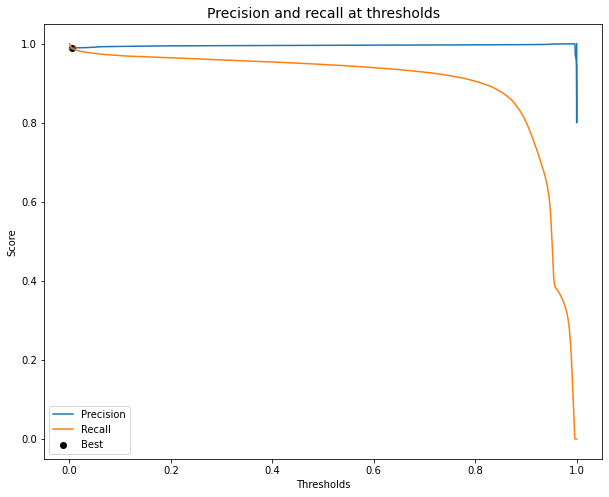

In [39]:
# Using recall and precision at thresholds to find the middle ground for both
plt.figure(figsize=(10, 8))
plt.plot(thresholds, precision[0:-1], label="Precision")
plt.plot(thresholds, recall[0:-1], label="Recall")
plt.scatter(thresholds[intersection_index], precision[intersection_index], marker='o', color='black', label='Best')
plt.xlabel('Thresholds')
plt.ylabel('Score')
plt.legend()
plt.title("Precision and recall at thresholds", fontsize=14)
plt.show()

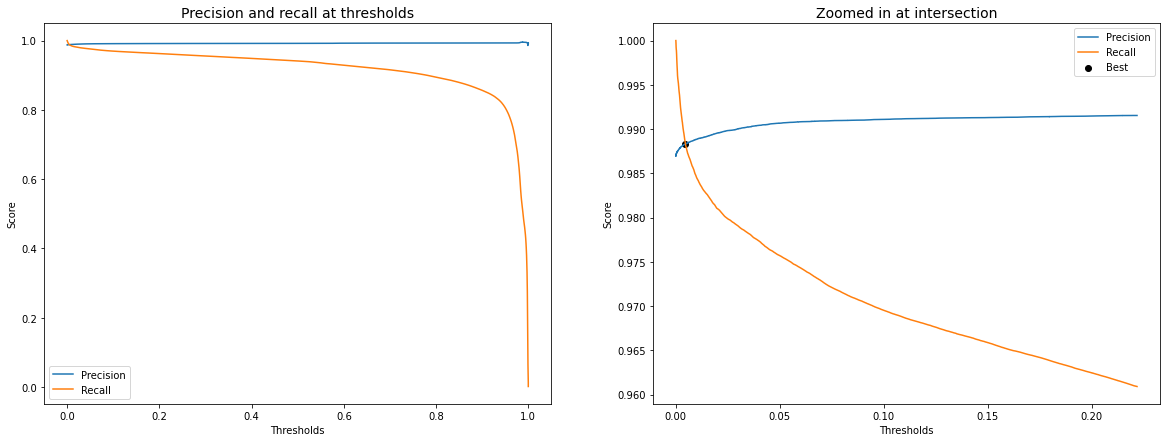

In [26]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7))

ax1.plot(thresholds, precision[0:-1], label="Precision")
ax1.plot(thresholds, recall[0:-1], label="Recall")
ax1.set_xlabel('Thresholds')
ax1.set_ylabel('Score')
ax1.legend()
ax1.set_title("Precision and recall at thresholds", fontsize=14)

half = int(len(precision)/10)
ax2.plot(thresholds[0:half], precision[0:half], label="Precision")
ax2.plot(thresholds[0:half], recall[0:half], label="Recall")
ax2.scatter(thresholds[intersection_index], precision[intersection_index], marker='o', color='black', label='Best')
ax2.set_xlabel('Thresholds')
ax2.set_ylabel('Score')
ax2.legend()
ax2.set_title("Zoomed in at intersection", fontsize=14)

plt.show()

In [40]:
preds, acts = evaluate_result(predictions, actual, thresholds[intersection_index])

In [43]:
preds, acts = evaluate_result(predictions, actual, 0.1)

In [44]:
get_scores(preds, acts)

Confusion matrix:
[[   6922    7238]
 [  32239 1036414]]


Accuracy score:
0.9635421813369437


Recall score:
0.9698321157569388


F1 score:
0.9813109375776699




In [45]:
visualize_df = pd.DataFrame(xyz_points, columns=["x", "y", "z"])
visualize_df["accepted"] = preds

In [46]:
visualize_area(visualize_df, voxel_size=0.05)

[Open3D WARNING] [ViewControl] ConvertFromPinholeCameraParameters() failed because window height and width do not match.
